In [29]:
import numpy as np
np.random.seed(1337)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os
os.environ['OMP_NUM_THREADS'] = '10'

import matplotlib.pyplot as plt
%matplotlib inline

import string
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
stopWords.add("im")

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15471890604045889725
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 456720384
locality {
  bus_id: 1
}
incarnation: 14796605945170394377
physical_device_desc: "device: 0, name: Graphics Device, pci bus id: 0000:01:00.0"
]


In [4]:
EMBEDDING_FILE = '../../../../Downloads/fasttext/wiki.en.vec'

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')


In [5]:
X_train = train["comment_text"].fillna("fillna")
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna")

### Add in some minor cleaning processing before words are vectorized/embedded

In [12]:
def strip_line(line):
    punct = set(string.punctuation)

    line = line.replace(",", " ").replace("\n", " ")
    line = line.replace("..", " ").replace("??", " ").replace("!!", " ")
    line = line.replace(". ", " EOS ").replace("? ", " EOS ").replace("! ", " EOS ")
    line = "".join([_c if _c not in punct else " " for _c in line])

    word_list = line.lower().split()
    
    # in the case of an empty string
    if len(word_list) > 0:
        
#         print(len(word_list))

        # if a sentence doesn't have eos add it?
        # might want to remove this when evaluating, not having terminating punctuation
        # is probably signal
        if word_list[-1] != "eos":
            word_list.append("eos")

        line = " ".join(word_list)
    #     print(line)

    #     if "yourselfgo" in line:
    #         print("#########", line)
    
    return line

X_train = X_train.apply(strip_line)
X_test = X_test.apply(strip_line)

In [13]:
max_features = 50000
maxlen = 200
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train.values) + list(X_test.values))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [14]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

            
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, batch_size=1024)
        
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val, batch_size=1024)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,6)),str(round(roc_val,6))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [7]:
def get_model(learning_rate=0.01, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [8]:
def get_model2(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
    
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [9]:
def get_model3(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(60, return_sequences=True))(x)
        
    x = Bidirectional(GRU(60, return_sequences=True))(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [16]:
def get_model4(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(drop_out)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [ ]:
model = get_model4(learning_rate=0.001, lr_decay=0, drop_out=0.35)

# dropout:  0.0    ROC AUC:  0.984483  Epochs = 2  lr_decay = 0.0001


# print(model.summary())

batch_size = 256
epochs = 4

# stratified k-fold
skf = KFold(n_splits=8, random_state=46436, shuffle=True)
skf.get_n_splits(x_train, y_train)

count = 0
for train_index, test_index in skf.split(x_train, y_train):
    count += 1 
    
    # don't actually evaluate all folds
    if count > 4:
        break
    
    X_tra, X_val = x_train[train_index], x_train[test_index]
    y_tra, y_val = y_train[train_index], y_train[test_index]

    hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                     callbacks=[roc_callback(training_data=(X_tra, y_tra),validation_data=(X_val, y_val))],
                     verbose=1)

Train on 139624 samples, validate on 19947 samples
Epoch 1/4
139624/139624 [==============================] - 145s 1ms/step - loss: 0.0784 - acc: 0.9747 - val_loss: 0.0475 - val_acc: 0.9830
roc-auc: 0.975143 - roc-auc_val: 0.971863                                                                                                    
Epoch 2/4
139624/139624 [==============================] - 144s 1ms/step - loss: 0.0444 - acc: 0.9833 - val_loss: 0.0421 - val_acc: 0.9841
roc-auc: 0.987075 - roc-auc_val: 0.982571                                                                                                    
Epoch 3/4
139624/139624 [==============================] - 144s 1ms/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0408 - val_acc: 0.9845
roc-auc: 0.991603 - roc-auc_val: 0.985057                                                                                                    
Epoch 4/4
139624/139624 [==============================] - 144s 1ms/step - loss: 0.0342 - acc: 0.9865 - va

### evaluate using folds

In [ ]:
model = get_model4(learning_rate=0.001, lr_decay=0, drop_out=0.2)

# dropout:  0.0    ROC AUC:  0.984483  Epochs = 2  lr_decay = 0.0001
# dropout:  0.1    ROC AUC:  0.984710  Epochs = 3  lr_decay = 0.0001
# dropout:  0.15   ROC AUC:  0.985498  Epochs = 3  lr_decay = 0.0001
# dropout:  0.2    ROC AUC:  0.985565  Epochs = 3  lr_decay = 0.0
# dropout:  0.2    ROC AUC:  0.985754  Epochs = 3  lr_decay = 0.0001
# dropout:  0.25   ROC AUC:  0.985583  Epochs = 3  lr_decay = 0.0001
# dropout:  0.3    ROC AUC:  0.000000  Epochs = 3  lr_decay = 0.0001



# dropout:  0.2    ROC AUC:  0.985565  Epochs = 2  lr_decay = 0.0  batch=32
# dropout:  0.2    ROC AUC:  0.986987  Epochs = 2  lr_decay = 0.0  batch=32

# print(model.summary())

batch_size = 256
epochs = 3

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.90, random_state=233)
# RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[roc_callback(training_data=(X_tra, y_tra),validation_data=(X_val, y_val))],
                 verbose=1)

In [19]:
y_pred = model.predict(x_test, batch_size=1024)
# y_pred2 = model2.predict(x_test, batch_size=1024)

In [28]:
merged = np.zeros((len(y_pred1), 6))

for idx in range(6):
    merged[:, idx] = (y_pred[:, idx] + y_pred2[:, idx]) / 2

In [29]:
merged[:10]

array([[  9.98292387e-01,   5.93660593e-01,   9.91719246e-01,
          3.72165106e-02,   9.28416014e-01,   4.32196796e-01],
       [  1.40022064e-04,   1.01796131e-05,   6.16115794e-05,
          8.99722272e-06,   4.76860114e-05,   1.23059281e-05],
       [  1.14991493e-03,   7.12961919e-05,   2.82173394e-04,
          4.55172121e-05,   1.83624114e-04,   6.69745641e-05],
       [  3.71524104e-04,   8.35616174e-06,   1.22842685e-04,
          2.82676701e-05,   8.56951301e-05,   1.14385321e-05],
       [  3.66054359e-03,   9.58527380e-05,   1.00996590e-03,
          3.15602025e-04,   2.06569748e-04,   6.26511464e-05],
       [  1.23645563e-03,   3.40508195e-05,   2.69324024e-04,
          5.55364168e-05,   1.52903711e-04,   2.52701066e-05],
       [  2.05831714e-02,   5.29726349e-05,   9.50353220e-04,
          3.54499425e-05,   2.49279290e-03,   1.23235004e-04],
       [  6.36242807e-01,   1.88994245e-03,   1.05181914e-02,
          3.01735965e-03,   3.86921950e-02,   2.28222134e-03],


In [133]:
file_name_base = "../models/model4_pooled_gru_lb0918"

model.save(file_name_base + ".h5")

# save as JSON
json_string = model.to_json()
json_out = file_name_base + ".json"

with open(json_out, "w") as outfile:
    outfile.write(json_string)

In [20]:
msubmission = pd.read_csv('../data/sample_submission.csv')
msubmission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
msubmission.to_csv('../submissions/fod_checked_merged_pooled_gru_fasttext_submission.csv.gz', index=False, compression="gzip")

In [35]:
msubmission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998292,0.593661,0.991719,0.037217,0.928416,0.432197
1,0000247867823ef7,0.000140,0.000010,0.000062,0.000009,0.000048,0.000012
2,00013b17ad220c46,0.001150,0.000071,0.000282,0.000046,0.000184,0.000067
3,00017563c3f7919a,0.000372,0.000008,0.000123,0.000028,0.000086,0.000011
4,00017695ad8997eb,0.003661,0.000096,0.001010,0.000316,0.000207,0.000063


In [36]:
msubmission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153164 entries, 0 to 153163
Data columns (total 7 columns):
id               153164 non-null object
toxic            153164 non-null float64
severe_toxic     153164 non-null float64
obscene          153164 non-null float64
threat           153164 non-null float64
insult           153164 non-null float64
identity_hate    153164 non-null float64
dtypes: float64(6), object(1)
memory usage: 9.3+ MB


In [32]:
submission = pd.read_csv('../data/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('../submissions/more_features_pooled_gru_fasttext_submission.csv.gz', index=False, compression="gzip")

In [33]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998292,0.593661,0.991719,0.037217,0.928416,0.432197
1,0000247867823ef7,0.000140,0.000010,0.000062,0.000009,0.000048,0.000012
2,00013b17ad220c46,0.001150,0.000071,0.000282,0.000046,0.000184,0.000067
3,00017563c3f7919a,0.000372,0.000008,0.000123,0.000028,0.000086,0.000011
4,00017695ad8997eb,0.003661,0.000096,0.001010,0.000316,0.000207,0.000063


#### Create a generic sample submission to be overwritten by the above

In [21]:
sample_submission = test
for _class in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
    sample_submission[_class] = 0

In [22]:
print(sample_submission.keys())

sample_submission = sample_submission.drop(["comment_text"], axis=1)
sample_submission.head()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0,0,0,0,0,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [23]:
sample_submission.to_csv("../data/sample_submission.csv", index_label=False)

In [51]:
np.log2(32000)

14.965784284662087

#### Plot an ROC for the model

In [22]:
val_preds = model.predict(X_val, batch_size=1024)

0.981324296918
0.991561611186
0.991862552368
0.989779948408
0.984572105722
0.983068360665


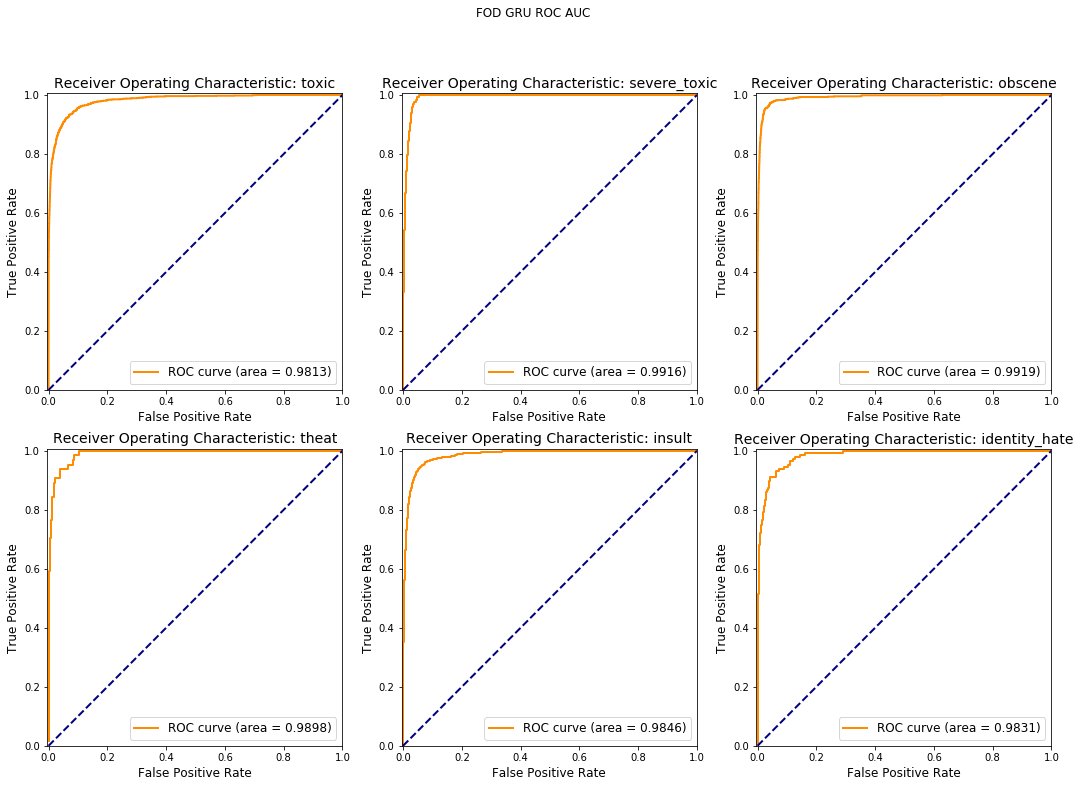

In [24]:
c_names = ["toxic", "severe_toxic", "obscene", "theat", "insult", "identity_hate"]

fig, axs = plt.subplots(2, 3, figsize=(18,12))

fig.set_facecolor("white")
fig.suptitle("FOD GRU ROC AUC")

for _c in range(6):
    class_index = _c
    class_name = c_names[_c]

    result = roc_auc_score(y_val[:, class_index], val_preds[:, class_index])

    fpr = {}
    tpr = {}
    fpr, tpr, _ = roc_curve(y_val[:, class_index], val_preds[:, class_index])
    roc_auc = auc(fpr, tpr)

    # print(fpr)
    print(result)

    ax = axs.flatten()[_c]

    ax.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc)


    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.005])
    ax.set_xlabel('False Positive Rate', size=12)
    ax.set_ylabel('True Positive Rate', size=12)
    ax.set_title('Receiver Operating Characteristic: ' + class_name, size=14)
    ax.legend(loc="lower right", fontsize=12)
    # plt.show()